In [2]:
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from mpmath import *
from matplotlib.pyplot import figure, show, rc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
% matplotlib inline

In [3]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [4]:
#Rotation matrix using Rodrigues Formula

def rotation_matrix(axis, rotation_angle):
    
    #Normalize axis
    
    axis = np.array(axis)
    axis_normalized = axis/np.sqrt(np.dot(axis.T, axis))
    a = np.cos(rotation_angle/2)
    b = -axis_normalized[0]*np.sin(rotation_angle/2)
    c = -axis_normalized[1]*np.sin(rotation_angle/2)
    d = -axis_normalized[2]*np.sin(rotation_angle/2)
    rot_mat = np.array([[a**2+b**2-c**2-d**2, 2*(b*c-a*d), 2*(b*d+a*c)], 
                       [2*(b*c+a*d), a**2+c**2-b**2-d**2, 2*(c*d-a*b)],
                      [2*(b*d-a*c), 2*(c*d+a*b), (a**2+d**2-b**2-c**2)]])
    
    return(rot_mat)

In [5]:
def stress_rotation(phi_mcs, theta_mcs, rho):

    R_strike = rotation_matrix(np.array([0, 0 , 1]), phi_mcs)
    R_dip = rotation_matrix(np.array([0, 1 , 0]), theta_mcs)
    R_check = np.dot(R_dip, R_strike)
    rho_axis = R_check[:, 0]
    R_rho = rotation_matrix(-rho_axis, rho)
    R_final = np.dot(R_rho, R_check)
    
    return R_final


In [6]:
def normalize(V):
    
    V_norm = V/np.sqrt(np.dot(V.T, V))
    
    return V_norm

In [49]:
N = np.array([-1, 0, 0])
E = np.array([0, 1, 0])
D = np.array([0, 0, -1])

M = np.array([[0, 0, 0], [0, -1, 0], [0, 0, 1]])

R1 = rotation_matrix([1, 0, 0], np.pi)
R2 = rotation_matrix([0, 0, 1], np.pi)

x = np.array([1, 0, 0])
y = np.array([0, 1, 0])
z = np.array([0, 0, 1])
R = np.dot(R2, R1)
Rinv = np.linalg.inv(R)

xp = np.dot(R, x)
yp = np.dot(R, y)
zp = np.dot(R, z)


phi = 0
delta = np.pi/4
lamda = np.pi/2

fault_normal = np.array([-np.sin(delta)*np.sin(phi), np.sin(delta)*np.cos(phi), -np.cos(delta)])
fault_slip = np.array([np.cos(lamda)*np.cos(phi)+np.cos(delta)*np.sin(lamda)*np.sin(phi), np.cos(lamda)
                       *np.sin(phi)-np.cos(delta)*np.sin(lamda)*np.cos(phi), -(np.sin(delta)*np.sin(lamda))])
null = np.cross(fault_normal, fault_slip)

#print(fault_normal)
#print(fault_slip)

In [50]:
vals, V = np.linalg.eig(np.dot(np.dot(R, M), R.T))
print(V)
null = V[:, 0]
T = V[:, 1]
P = V[:, 2]

[[  1.00000000e+00   1.22464680e-16  -1.49975978e-32]
 [  0.00000000e+00  -1.00000000e+00   1.22464680e-16]
 [  0.00000000e+00   2.44929360e-16   1.00000000e+00]]


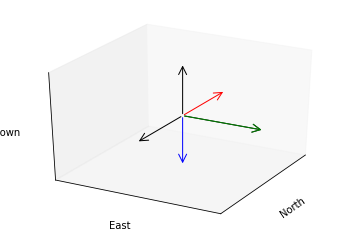

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])


axis1 = Arrow3D([0, x[0]], [0, x[1]], [0, x[2]],mutation_scale=20, lw=1, arrowstyle="->", color="k")
axis2 = Arrow3D([0, y[0]], [0, y[1]], [0, y[2]],mutation_scale=20, lw=1, arrowstyle="->", color="k")
axis3 = Arrow3D([0, z[0]], [0, z[1]], [0, z[2]],mutation_scale=20, lw=1, arrowstyle="->", color="k")

vector1 = Arrow3D([0, xp[0]], [0, xp[1]], [0, xp[2]],mutation_scale=20, lw=1, arrowstyle="->", color="r")
vector2 = Arrow3D([0, yp[0]], [0, yp[1]], [0, yp[2]],mutation_scale=20, lw=1, arrowstyle="->", color="g")
vector3 = Arrow3D([0, zp[0]], [0, zp[1]], [0, zp[2]],mutation_scale=20, lw=1, arrowstyle="->", color="b")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.add_artist(axis1)
ax.add_artist(axis2)
ax.add_artist(axis3)

ax.add_artist(vector1)
ax.add_artist(vector2)
ax.add_artist(vector3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel('North')
ax.set_ylabel('East')
ax.set_zlabel('Down')




for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()


plt.show()

In [30]:
def trend_plunge(vec):
    
    vec = np.array(vec)
    trend = np.arctan2(vec[1], vec[0])*180/np.pi
    plunge = np.arctan2(-vec[2], np.sqrt(vec[1]**2+vec[0]**2))*180/np.pi
    
    return trend, plunge
    

In [31]:
t_1, p_1 = trend_plunge([-1, 0, 0])
t_2, p_2 = trend_plunge([0, 0, -1])
t_3, p_3 = trend_plunge([0, 1, 0])

print(null)
print(T)
print(P)

t_null, p_null = trend_plunge(null)
t_T, p_T = trend_plunge(T)
t_P, p_P = trend_plunge(P)

[ 1.  0.  0.]
[ 0.  1.  0.]
[ 0.  0.  1.]


In [32]:
print(t_null, p_null)
print(t_T, p_T)
print(t_P, p_P)

0.0 -0.0
90.0 -0.0
0.0 -90.0
